## Revised Real Data Analysis

#### Objective 1: Calculate Density estimates for each flight
#### Objective 2: Calculate variance via bootstrapping - confidence intervals
#### Objective 3: Illustrate on log scale

### Objective 1

In [1]:
rm(list=ls())

suppressMessages(library(dplyr))
library(tidyr)
library(geosphere)
suppressMessages(library(reshape2))
library(ggplot2)
library(ggthemes)
library(xtable)


# Import cleaned datasets from the Data_Wrangling
source('Data_Wrangling.R')

# Import original files for duration 
original_biot <- read.csv("../Data/Metadata/BIOT/BIOT_2018.csv", header = T)
original_biot <- subset(original_biot, original_biot$Flight.or.Grounded == 'Flight') # All images in flight
# Subset by particular flights
flights_chosen <- c(1,3,7,8,10,11,12)
original_biot <- original_biot[original_biot$Flight %in% flights_chosen,]
original_belize <- belize
#original_belize

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following objects are masked from ‘package:dplyr’:

    combine, first, last

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



In [2]:
biot_sum <- biot_lite %>%
  group_by(Flight) %>% 
  tally(c(Reefshark, Nurseshark, Whaleshark, Eagleray, Mantaray, Whitetern, 
          Sootytern, Tern_other, Redfootedboobie, Frigatebird, Brownnoddy_any, 
          Bird, FruitBat, Human))

belize_sum <- belize_lite %>%
  group_by(Flight) %>% 
  tally(c(eagle.ray,turtle,manatee,shark,ray))


total_count <- rbind(biot_sum, belize_sum)
# Rename Belize flights
total_count[8,1] <- 13
total_count[9,1] <- 14
total_count[10,1] <- 15
total_count[11,1] <- 16
total_count[12,1] <- 17
total_count[13,1] <- 18

total_count

Flight,n
<dbl>,<dbl>
1,4
3,3
7,2
8,5627
10,2
11,2
12,13
13,5
14,2


In [3]:
Species_count_biot <- biot_lite %>%
  group_by(Flight) %>% 
  summarise(Reef = sum(Reefshark),
            Nurse = sum(Nurseshark),
            Whale = sum(Whaleshark),
            Eagle = sum(Eagleray),
            Manta = sum(Mantaray),
            White = sum(Whitetern),
            Sooty = sum(Sootytern),
            Tern = sum(Tern_other),
            Booby = sum(Redfootedboobie),
            Frigate= sum(Frigatebird),
            Noddy = sum(Brownnoddy_any),
            Bird = sum(Bird))

Species_count_belize <- belize_lite %>%
  group_by(Flight) %>% 
  summarise(Eagle = sum(eagle.ray),
            Turtle = sum(turtle), 
            Manatee = sum(manatee),
            Shark = sum(shark),
            Ray  = sum (ray))

Species_count_biot <- as.data.frame(Species_count_biot)
Species_count_biot <- Species_count_biot[-4,]
Species_count_belize <- as.data.frame(Species_count_belize)

counts <- apply(Species_count_biot, 2, function(x) sum(x))
counts2 <- apply(Species_count_belize, 2, function(x) sum(x))
                 
counts <- counts[-1] # Remove flight number
counts2 <- counts2[-1]
                 
all_counts <- c(counts, counts2)
all_counts <- as.data.frame(t(all_counts))
Eagle <- all_counts[4] + all_counts[13]
all_counts <- all_counts[-4]
all_counts <- all_counts[-12]
all_counts <- cbind(all_counts, Eagle)
all_counts <- sort(all_counts, decreasing = T)
write.csv(all_counts, file = "../Results/Species_count.csv")

In [4]:
Species_count_biot
Species_count_belize

,Flight,Reef,Nurse,Whale,Eagle,Manta,White,Sooty,Tern,Booby,Frigate,Noddy,Bird
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,2,0,0,0,0,0,0,0,2,0,0,0
2,3,1,0,0,0,0,0,0,2,0,0,0,0
3,7,0,1,0,0,0,1,0,0,0,0,0,0
5,10,0,0,1,0,1,0,0,0,0,0,0,0
6,11,0,0,0,1,0,0,0,0,0,0,0,0
7,12,1,0,0,0,0,0,0,0,0,0,0,0


Flight,Eagle,Turtle,Manatee,Shark,Ray
<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,3,2,0,0,0
2,0,0,0,0,2
3,0,0,2,0,0
4,2,0,0,0,0
5,0,0,2,0,0
6,2,0,0,0,0


In [5]:
################## Calculate Elapsed Time in Seconds #####################


# Original metadata file duration
# Can I use the full flight biot time on the biot_lite dataset? I would say yes because the overlap is only to fix encounter rate and calculate area
# Full flight duration used to calculate accurate speed


Duration_per_flight <- function(df){
    time <- df %>% 
        group_by(Flight) %>%
            summarise(Duration = length(Flight))
    
    return(time[,2])
}


Images_biot <- Duration_per_flight(original_biot)
# Belize duration from LOG_BELIZE_FLIGHTS.xlsx acording to observer (first 10 flights)
Duration <- rbind(Images_biot, (18*60), (20*60), (15*60), (12*60), (15*60), (25*60))

total_count <- cbind(total_count, Duration)


total_count

Flight,n,Duration
<dbl>,<dbl>,<dbl>
1,4,429
3,3,735
7,2,1185
8,5627,1126
10,2,314
11,2,1042
12,13,1224
13,5,1080
14,2,1200


In [6]:
################## Calculate Distance in Metres #########################


# Geodesic distance between two points specified by radian latitude/longitude
# VincentyEllipsoid formula specified as most accurate
# Was stuck between calculating distance with full biot or biot_lite 
# Would use biot to account for full distance (specifically at end of flight) but as t is being factored into area later...



Calculate_dist_per_flight <- function(flight_no, d){
  # Distance calculated in metres
  df <- subset(d, d$Flight == flight_no, select = c(Lat, Long))
  pts <- df[c("Long", "Lat")] # Dataframes lagged by one point so as to calculate distance
  segDists <- distVincentyEllipsoid(p1 = pts[-nrow(df),], 
                                    p2 = pts[-1,])
  return(sum(segDists))
}


Calculate_distance <- function(df){
  Distance <- c()
  Flight_no <- c()
  Flights <- unique(df$Flight)
  for(i in Flights){
    Flight_no <- c(Flight_no, i)
    dist <- Calculate_dist_per_flight(i, df)
    Distance <- c(Distance, dist)
  }
  x <- cbind.data.frame(Flight_no, Distance)
  return(x)
}


# Add vector to df
Distance_BIOT <- Calculate_distance(original_biot)
Distance_belize <- Calculate_distance(original_belize)
Distance <- rbind(Distance_BIOT, Distance_belize)

f7 <- 10.7*1000
f8 <- 13.1*1000
#f10 <- 5.74*1000
f11 <- 33.5*1000
f12 <- 33.5*1000

# Use recorded distances on log instead of calculated - slightly off but who knows.
#f13 <- 10.89*1000

Distance[3,2] <- f7
Distance[4,2] <- f8
#Distance[5,2] <- f10
Distance[6,2] <- f11
Distance[7,2] <- f12

total_count <- cbind(total_count, Distance$Distance)
#total_count <- cbind(total_count, Distance$Distance/1000)
#total_count <- total_count[,-4]

names(total_count)[2] <- "Captures"
names(total_count)[3] <- "Duration_(seconds)"
names(total_count)[4] <- "Distance_(m)"

total_count

Flight,Captures,Duration_(seconds),Distance_(m)
<dbl>,<dbl>,<dbl>,<dbl>
1,4,429,1718.5112
3,3,735,8892.4914
7,2,1185,10700.0000
8,5627,1126,13100.0000
10,2,314,130.5973
11,2,1042,33500.0000
12,13,1224,33500.0000
13,5,1080,17112.5876
14,2,1200,12372.2725


In [7]:
### Speed

total_count <- total_count %>% mutate(Speed <- (total_count [,4]/ total_count [,3]))
names(total_count)[5] <- "Average_Speed_(m/s)"

total_count

Flight,Captures,Duration_(seconds),Distance_(m),Average_Speed_(m/s)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,429,1718.5112,4.0058535
3,3,735,8892.4914,12.0986277
7,2,1185,10700.0000,9.0295359
8,5627,1126,13100.0000,11.6341030
10,2,314,130.5973,0.4159151
11,2,1042,33500.0000,32.1497121
12,13,1224,33500.0000,27.3692810
13,5,1080,17112.5876,15.8449885
14,2,1200,12372.2725,10.3102271


In [8]:
####### Area Calculations 

# Garmin (BIOT)
g_sensor.h <- 4.55
g_sensor.v <- 6.17
g_f <- 2.73
g_alt <- 50

# Sony DSLR ILCE-5100 (Maldives)
s_sensor.h <- 23.5
s_sensor.v <- 15.6
s_f <- 16
s_alt <- 77.5

# Sony RX0 Nadir (Belize)
n_sensor.h <- 13.2
n_sensor.v <- 18.88
n_f <- 7.7
n_alt <- 90


g_coverage.h <- (g_sensor.h/g_f)*g_alt
g_coverage.v <- (g_sensor.v/g_f)*g_alt

s_coverage.h <- (s_sensor.h/s_f)*s_alt
s_coverage.v <- (s_sensor.v/s_f)*s_alt

n_coverage.h <- (n_sensor.h/n_f)*n_alt
n_coverage.v <- (n_sensor.v/n_f)*n_alt


# Split total table by camera model
biot <- total_count[1:5,]
maldives <- total_count[6:7,]
belize <- total_count[8:13,]


##### gREM Area method #######

gREMarea <- function(detection_width, v, t){
    return(A <- detection_width*v*t)
}

#sarea <- function(detection_width, length){
#    return(A <- detection_width*length)
#}

Area_m2_biot <- apply(biot, 1, function(x) gREMarea(g_coverage.h, x[5], x[3]))
Area_km2_biot <- sapply(Area_m2_biot, function(x) x/1000000)
Area_m2_maldives <- apply(maldives, 1, function(x) gREMarea(s_coverage.h, x[5], x[3]))
Area_km2_maldives <- sapply(Area_m2_maldives, function(x) x/1000000)
Area_m2_belize <- apply(belize, 1, function(x) gREMarea(n_coverage.h, x[5], x[3]))
Area_km2_belize <- sapply(Area_m2_belize, function(x) x/1000000)
                            
Area_km2 <- c(Area_km2_biot, Area_km2_maldives, Area_km2_belize)
total_count <- cbind(total_count, Area_km2)
#total_count
g_coverage.v
s_coverage.v
n_coverage.v

[1] 113.0037

[1] 75.5625

[1] 220.6753

In [9]:
#################################### Calculating Density ###########################################


calcDensity <- function(z, A){
  # Calculate density using ideal gas model from capture rate and survey area covered
  # z : The number of encounters/captures.
  # A : Area covered by sensor per unit time.
  
    # Double check parameters
  if(z < 0 | !is.numeric(z)) stop("Number of individuals must be a positive number")
  if (A <= 0 | !is.numeric(A)) stop("Area, A, must be a positive number.")
  # Calculate density
  return(D <- z/A)
}


# Calculate Area (m2) and Density for each flight

Flight_Density <- function(total_df){
  # Calculate area and subsequent density for each flight
  Density_vec <- c()
  for(i in 1:nrow(total_df)){
    # Calculate densities for each area and capture rate
    Density <- calcDensity(total_df$`Captures`[i], total_df$`Area_km2`[i])
    Density_vec <- c(Density_vec, Density)
  }
  return(Density_vec)
}

Density_Estimate_km2 <- Flight_Density(total_count)

total_count <- cbind(total_count, Density_Estimate_km2)
total_count <- total_count[-4,]
#total_count2 <- total_count[-4,]
#total_count2
total_count

,Flight,Captures,Duration_(seconds),Distance_(m),Average_Speed_(m/s),Area_km2,Density_Estimate_km2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4,429,1718.5112,4.0058535,0.14320926,27.9311542
2,3,3,735,8892.4914,12.0986277,0.74104095,4.0483593
3,7,2,1185,10700.0000,9.0295359,0.89166667,2.2429907
5,10,2,314,130.5973,0.4159151,0.01088311,183.7709786
6,11,2,1042,33500.0000,32.1497121,3.81324219,0.5244881
7,12,13,1224,33500.0000,27.3692810,3.81324219,3.4091724
8,13,5,1080,17112.5876,15.8449885,2.64022781,1.8937760
9,14,2,1200,12372.2725,10.3102271,1.90886490,1.0477431
10,15,2,900,14315.5064,15.9061182,2.20867813,0.9055190


In [10]:
total_table <- xtable(total_count)
print.xtable(total_table, type = "latex", floating = F, caption.placement = "top", file = "../Results/tc_table.tex",
             include.rownames = F)
dev.off()

#write.table(total_count, file = "../Results/Flight_Summary.txt")

null device 
          1

In [11]:
#### Bootstrapping
dens <- total_count$Density_Estimate_km2

# storage for bootstraps
size = length(dens)
boot_n = 1000
boot_all = data.frame(matrix(0, nrow = boot_n, ncol = 2))

for (i in 1:boot_n){
    boot_dens = sample(dens, size, replace = T)
    boot_all[i, 1] = mean(boot_dens)
    boot_all[i, 2] = mean(boot_dens) - mean(dens)
}


distances = sort(boot_all$X1)
lower = distances[0.025*length(distances)]
upper = distances[0.975*length(distances)]
#hist(distances)
#abline(v = mean(dens), col="red")
#abline(v = mean(distances), col="blue")
#abline(v = upper, col="green")
#abline(v = lower, col="green") 


#summary(dens)
#summary(density)
#lower
#upper

true_mean = mean(dens)
boot_mean = mean(boot_all$X1)
#true_mean
#boot_mean
fig1 <- ggplot(data = boot_all, aes(x = X1)) +
        geom_histogram(bins = 25, fill = 'skyblue3') +  
        geom_vline(xintercept = true_mean, col="red2") +
        geom_vline(xintercept = boot_mean, col="blue") +
        geom_vline(xintercept = lower, col="darkblue", linetype = 'dotted') +
        geom_vline(xintercept = upper, col="darkblue", linetype = 'dotted') +
        ylab("Frequency") +
        xlab(expression(paste(
                        "Density Estimate (per ",
                         km^2,
                        ")", sep=""))) + 
        theme_classic()

#fig1

In [21]:
pdf(file = paste("../Results/fig1.pdf"))
print(fig1)
dev.off()

png 
  2

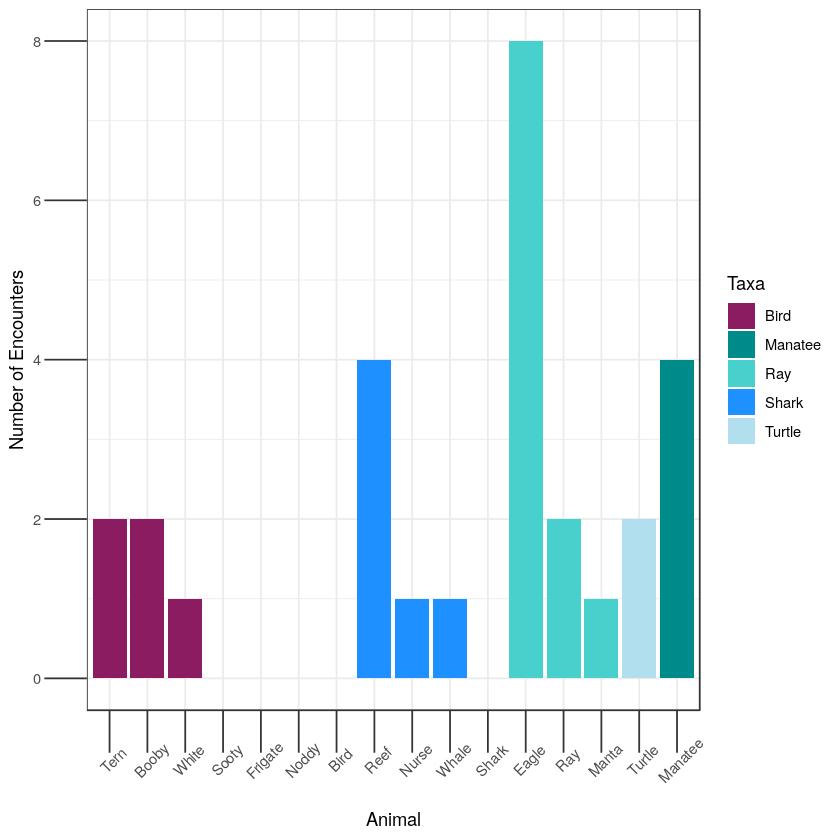

In [12]:
all_spec <- as.data.frame(t(all_counts))
all_spec$Animal <- rownames(all_spec)

                  
birds <- c('Bird', 'Noddy', 'Frigate', 'Booby', 'Sooty', 'Tern', 'White')
sharks <- c('Nurse', 'Reef', 'Whale', 'Shark')
rays <- c('Eagle', 'Manta', 'Ray')
turtle <- c('Turtle')
manatee <- c('Manatee')

col3.5 <- c()
for(i in all_spec$Animal){
    if(i %in% birds){
        col3.5 <- c(col3.5, 1)
    }
     if(i %in% sharks){
        col3.5 <- c(col3.5, 2)
    }
     if(i %in% rays){
        col3.5 <- c(col3.5, 3)
    }
     if(i %in% turtle){
        col3.5 <- c(col3.5, 4)
    }
     if(i %in% manatee){
        col3.5 <- c(col3.5, 5)
    }
}

all_spec[,3] <- as.character(col3.5)

                  
                  
all_spec <- all_spec %>% 
        group_by(V3) %>%
        arrange(V3, .by_group = TRUE)
    
all_spec$Animal <- factor(all_spec$Animal, levels = all_spec$Animal[order(all_spec$V3)])

                  
all_spec$V3[all_spec$V3 == 1] <- "Bird"
all_spec$V3[all_spec$V3 == 2] <- "Shark"  
all_spec$V3[all_spec$V3 == 3] <- "Ray"
all_spec$V3[all_spec$V3 == 4] <- "Turtle"
all_spec$V3[all_spec$V3 == 5] <- "Manatee"  
                  
names(all_spec)[3] <- 'Taxa'
  


            
tcno8_encounter <- ggplot(data = all_spec, aes(x = all_spec$Animal, y = all_spec$V1)) +
  geom_bar(aes(fill = Taxa), stat = 'identity') +
  xlab("Animal") +
  ylab("Number of Encounters") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45), axis.ticks.length = unit(.9, "cm")) +
  scale_fill_manual(values = c("maroon4", "darkcyan", "mediumturquoise", "dodgerblue1", "lightblue2"))



Prop <- sapply(all_spec$V1, function(x) (x/sum(all_spec$V1))*100)

tcno8_encounter

In [13]:
pdf(file = paste("../Results/appendix1.pdf"))
print(tcno8_encounter)
dev.off()

png 
  2

In [45]:
row.names(total_count) <- 1:nrow(total_count)
total_count

Flight,Captures,Duration_(seconds),Distance_(m),Average_Speed_(m/s),Area_km2,Density_Estimate_km2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,429,1718.5112,4.0058535,0.14320926,27.9311542
3,3,735,8892.4914,12.0986277,0.74104095,4.0483593
7,2,1185,10700.0000,9.0295359,0.89166667,2.2429907
10,2,314,130.5973,0.4159151,0.01088311,183.7709786
11,2,1042,33500.0000,32.1497121,3.81324219,0.5244881
12,13,1224,33500.0000,27.3692810,3.81324219,3.4091724
13,5,1080,17112.5876,15.8449885,2.64022781,1.8937760
14,2,1200,12372.2725,10.3102271,1.90886490,1.0477431
15,2,900,14315.5064,15.9061182,2.20867813,0.9055190


In [13]:
garmin <- total_count[1:4,]
sony <- total_count[5:6,]
nadir <- total_count[7:12,]

#garmin
#maldives

   [1] -52.2553800 -52.2553800 -52.2553800 -52.2553800 -52.2553800 -51.8040379
   [7] -51.8040379 -51.8040379 -51.8040379 -51.8040379 -51.8040379 -51.8040379
  [13] -51.8040379 -51.8040379 -51.8040379 -51.8040379 -51.8040379 -51.8040379
  [19] -51.8040379 -51.8040379 -51.3526957 -51.3526957 -51.3526957 -51.3526957
  [25] -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957
  [31] -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957
  [37] -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957
  [43] -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957 -51.3526957
  [49] -50.9013536 -50.9013536 -50.9013536 -50.9013536 -50.9013536 -50.9013536
  [55] -50.9013536 -50.9013536 -50.9013536 -50.9013536 -50.9013536 -50.9013536
  [61] -50.9013536 -50.9013536 -50.9013536 -50.9013536 -50.9013536 -50.9013536
  [67] -50.9013536 -50.9013536 -50.4500114 -50.4500114 -50.4500114 -50.4500114
  [73] -50.4500114 -45.8333392 -45.8333392 -45.83333

   [1] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
   [8] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [15] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [22] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [29] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [36] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [43] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [50] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [57] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [64] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [71] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [78] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342
  [85] -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342 -1.442342

   [1] -0.280916148 -0.273777449 -0.247785515 -0.243966623 -0.240646816
   [6] -0.240646816 -0.236827924 -0.233508117 -0.233508117 -0.233508117
  [11] -0.227401307 -0.227401307 -0.225363038 -0.220262608 -0.220262608
  [16] -0.218224338 -0.218224338 -0.218224338 -0.216942800 -0.213123908
  [21] -0.213123908 -0.211085639 -0.211085639 -0.210835991 -0.210835991
  [26] -0.209804101 -0.208797721 -0.204978830 -0.204978830 -0.203697291
  [31] -0.203697291 -0.203697291 -0.202665402 -0.201659022 -0.201659022
  [36] -0.196558592 -0.196558592 -0.196558592 -0.196558592 -0.196558592
  [41] -0.196558592 -0.196558592 -0.196558592 -0.194520323 -0.194520323
  [46] -0.194520323 -0.194520323 -0.194520323 -0.194270674 -0.193238785
  [51] -0.192232405 -0.192232405 -0.190451783 -0.189419893 -0.189419893
  [56] -0.189419893 -0.189419893 -0.189419893 -0.188413513 -0.188413513
  [61] -0.188413513 -0.187381624 -0.187131975 -0.187131975 -0.187131975
  [66] -0.186375244 -0.186375244 -0.186375244 -0.186100085 -0.18

,Low,Mean,High,Camera
,<dbl>,<dbl>,<dbl>,<chr>
BIOT,-51.352696,54.498371,84.341953,BIOT
Maldives,-1.442342,1.966830,1.442342,Maldives
Belize,-0.210836,1.219566,0.305715,Belize


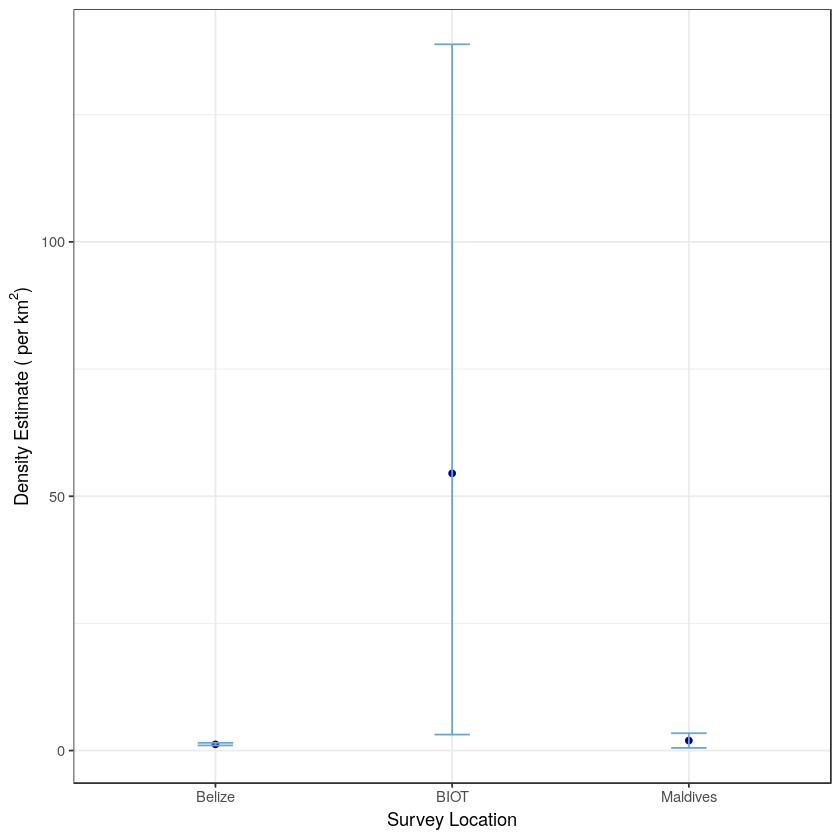

In [15]:
#### Between Camera models ######

bootstrap <- function(df){
    vect <- df$Density_Estimate_km2
    size = length(vect)
    #print(size)
    boot_n <- 1000
    boot_all  = data.frame(matrix(0, nrow = boot_n, ncol = 2)) # store bootstrap output
    for (i in 1:boot_n){
    boot_dens = sample(vect, size, replace = T)
    boot_all[i, 1] = mean(boot_dens)
    boot_all[i, 2] = mean(boot_dens) - mean(vect)
    }
    distances = sort(boot_all$X2)
    print(distances)
    lower = distances[0.025*length(distances)]
    upper = distances[0.975*length(distances)]
    output <- c(lower, mean(vect), upper)
   
    return(output)
}

g_boot <- bootstrap(garmin)
s_boot <- bootstrap(sony)
n_boot <- bootstrap(nadir)


cam_table <- data.frame(0, ncol=3, nrow =3)
colnames(cam_table) <- c("Low", "Mean", "High")
cam_table <- rbind(cam_table, g_boot, s_boot, n_boot)
row.names(cam_table) <-c('Table','BIOT', 'Maldives', 'Belize')
cam_table <-cam_table[-1,]

cam_table[ "Camera" ] <- rownames(cam_table)
#df.molten <- melt(cam_table, id.vars="Camera", value.name="Camera", variable.name="Variable" )
#df.molten


cam_table
#g_boot
#s_boot
#n_boot

cam_den <- ggplot(data = cam_table, aes(x = Camera, y = Mean)) +
  geom_point(colour = 'darkblue') +
  xlab('Survey Location') +
  ylab(expression(paste("Density Estimate ( per ",km^2,")", sep=""))) +
  geom_errorbar(aes(ymin=Mean + Low, ymax = Mean + High), width=.15,
  position=position_dodge(0.05), colour='skyblue3') + 
  theme_bw()

cam_den

In [16]:
pdf(file = paste("../Results/real_cam_den.pdf"))
print(cam_den)
dev.off()

png 
  2

In [17]:
cam_tab <- xtable(cam_table)
print.xtable(cam_tab, type = "latex", floating = T, caption.placement = "top", file = "../Results/camr_table.tex",
             include.rownames = F)

[1] 5.199267
[1] 0.9550013


[1] -4.937007  9.411430  8.786747

[1] -0.05002388  0.90497738  0.05002388

x,y,lower,upper
<fct>,<dbl>,<dbl>,<dbl>
Nurse,1.1223345,0.000,0.00
Whale,100.0000000,0.000,0.00
Reef,5.1992674,-4.937,8.79
Manatee,0.9550013,-0.050,0.05
Ray,0.7575758,0.000,0.00
Tern,2.6990553,0.000,0.00
Booby,14.2857143,0.000,0.00


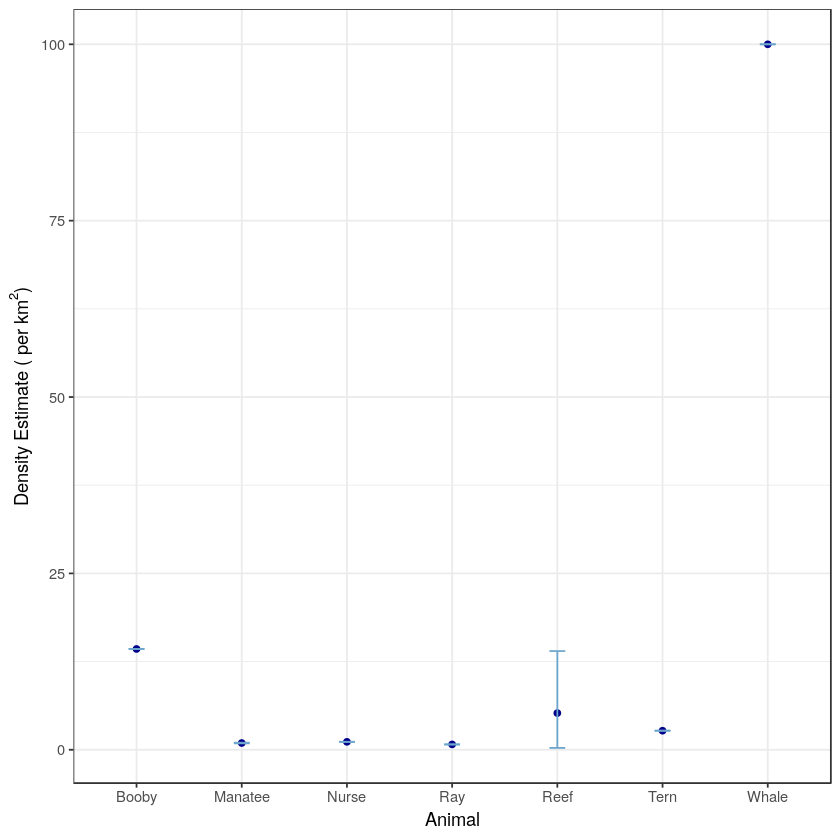

In [19]:
### Animal Est ####
abootstrap <- function(denv){
    vect <- denv
    print(mean(vect))
    size = length(vect)
    #print(size)
    boot_n <- 1000
    boot_all  = data.frame(matrix(0, nrow = boot_n, ncol = 2)) # store bootstrap output
    for (i in 1:boot_n){
    boot_dens = sample(vect, size, replace = T)
    boot_all[i, 1] = mean(boot_dens)
    boot_all[i, 2] = mean(boot_dens) - mean(vect)
    }
    distances = sort(boot_all$X2)
    #print(distances)
    lower = distances[0.025*length(distances)]
    upper = distances[0.975*length(distances)]
    output <- c(lower, mean(boot_dens), upper)
   
    return(output)
}


reef_den <- mean(c((2/0.143), (1/0.741), (1/3.813)))
nurse_den <- (1/0.891)
whale_den <- (1/0.01)
eagle_den <- (8/(3.81+2.64+1.63+1.61))
manta_den <- (1/0.01) # No speed - wasn't in sims
white_den <- (1/0.891) # No speed - wasn't in sims
# sooty not seen
tern_den <- (2/(0.741))
booby_den <- 2/0.14
# no frigate
# no noddy
# no general bird
turtle_den <- (2/2.64)
manatee_den <- mean(c((2/2.21), (2/1.99)))
# no shark
ray_den <- 2/2.64


ani_table <- data.frame(x = c('Nurse', 'Whale', 'Reef', 'Manatee', 'Ray','Tern', 'Booby'),
                       y = c(nurse_den, whale_den, reef_den, manatee_den, ray_den, tern_den, booby_den))

reef <- abootstrap(c((2/0.143), (1/0.741), (1/3.813)))
manatee <- abootstrap(c((2/2.21), (2/1.99)))


reef
manatee

lower <- c(0,0,-4.937,-0.05,0,0,0)
upper <- c(0,0,8.79,0.05,0,0,0)

ani_table <- cbind(ani_table, lower, upper)

ani_table


ani_den <- ggplot(data = ani_table, aes(x = x, y = y)) +
  geom_point(colour = 'darkblue') +
  xlab('Animal') +
  ylab(expression(paste("Density Estimate ( per ",km^2,")", sep=""))) +
  geom_errorbar(aes(ymin=y + lower, ymax = y + upper), width=.15,
  position=position_dodge(0.05), colour='skyblue3') + 
  theme_bw()

ani_den

In [20]:
ani_tab <- xtable(ani_table)
print.xtable(ani_tab, type = "latex", floating = T, caption.placement = "top", file = "../Results/anir_table.tex",
             include.rownames = F)